# Data integration

A central challenge in most scRNA-seq data analyses is presented by batch effects. Batch effects are transcriptomic manifestations of handling cells in distinct groups or “batches”. For example, a batch effect can arise if two labs have taken lung samples from the same cohort, but these samples are dissociated differently. If lab A optimizes their dissociation protocol to dissociate cells in the sample while minimizing the stress on them, and lab B does not, then it is likely that the cells in the data from the group B will express more stress-linked genes (JUN, JUNB, FOS, etc. see {cite}`VanDenBrink2022` 2-s2.0-85032485531) even if the cells had the same profile in the original tissue. In general, the origins of batch effects are diverse and difficult to pin down. Some batch effect sources might be technical such as differences in sample handling, experimental protocols, or sequencing depths, but also biological effects such as donor variation, tissue, or sampling location are often interpreted as a batch effect (see {cite}`Luecken2022` 10.1038/s41592-021-01336-8). Removing these effects is crucial to enable joint analysis that can focus on finding common structure in the data across batches. Often it is only after removing these effects that one can find rare cellular identities of which there are few per batch, and whose identification was previously obscured by differences between batches.

**NOTE: Optional extra text** -> include or not? This may overlap with our atlas building review. Opinions from Karin, Lisa here valuable.

When removing batch effects from omics data, one must make two central choices: (1) the method and parameterization, and (2) the batch covariate. As batch effects can arise between groupings of cells at different levels (i.e., samples, donors, datasets etc.), the choice of batch covariate indicates which level of variation should be retained and which level removed. The finer the batch resolution, the more effects will be regressed out. However, fine batch variation is also more likely to covary with biologically meaningful signals: Samples typically come from different individuals or different locations in the tissue. These effects may be meaningful to inspect. Thus, choosing the batch covariate will depend on the goal of your integration task: do you want to see differences between individuals, or are you focused on common cell type variation? A principled approach to batch covariate selection was pioneered in a recent effort to build an integrated atlas of the human lung, where the variance attributable to different covariates was used to make this choice {cite}`Sikkema2022`.

Methods that remove batch effects in scRNA-seq are typically composed of (up to) three steps:
1. Dimensionality reduction
2. Modeling and removing the batch effect
3. Projection back into a high-dimensional space

While modeling and removing the batch effect (Step 2) is the central part of any method, methods typically project the data to a lower dimensional space (Step 1) to improve the signal-to-noise ratio (see Dimensionality Reduction chapter) and thereby achieve better performance (see {cite}`Luecken2022`). In the third step, a method may project the data back into the high-dimensional space after removing the fitted batch effect to output a batch-corrected gene expression matrix.

**TODO:**
- crossref to dim red chapter


Batch-effect removal methods can vary in each of these three steps: they may use various linear or non-linear dimensionality reduction approaches, linear or non-linear batch effect models, and they may output different formats of batch-corrected data. Overall, we can divide methods for batch effect removal into 4 categories. In their order of development, these are: global models, linear embedding models, graph-based methods, and deep learning approaches. 

**Global models** originate from bulk RNA-seq and model the batch effect as a consistent (additive and/or multiplicative) effect across all cells. A common example is ComBat {cite}`Johnson2007` 10.1093/biostatistics/kxj037.

**Linear embedding models** were the first single-cell-specific batch removal methods. These approaches often use a variant of singular value decomposition (SVD) to embed the data, then look for local neighborhoods of similar cells across batches in the embedding, which they use to correct the batch effect in a locally adaptive manner. Methods often project the data back into gene expression space using the SVD loadings, but may also only output a corrected embedding. This is the most common group of methods and prominent examples include the pioneering mutual nearest neighbors (MNN) method {cite}`Haghverdi2018`, Seurat integration {cite}`Butler2018`, Scanorama {cite}, FastMNN {cite}, and Harmony {cite}.

**Graph-based methods** are typically the fastest methods to run. These approaches use some nearest-neighbor graph to represent the data from each batch. Batch effects are corrected by forcing connections between cells from different batches and then allowing for differences in cell type compositions by pruning the forced edges. The most prominent example of these approaches is the batch-balanced k-nearest neighbor (BBKNN) method {cite}.

**Deep learning (DL) approaches** are the most recent, and most complex methods for batch effect removal that typically require the most data for good performance. These approaches are based on autoencoder networks, and either condition the dimensionality reduction on the batch covariate in a conditional variational autoencoder (CVAE), or fit a locally linear correction in the embedded space. Prominent examples of DL methods are scVI {cite}, scANVI {cite}, and scGen {cite}.

Furthermore, some methods can make use of cell identity labels to provide the method with a reference for what a biological variation should not be removed as batch effect, thereby guiding the fitting and removal of the effect. As batch-effect removal is typically a preprocessing task, such approaches may not applicable to many integration scenarios.

More detailed overviews of batch-effect removal methods can be found in {cite}`Argelaguet2021` and {cite}`Luecken2022`. 


**TODO:**
- Make figure from my overview slide of data integration methods
- check naming: cell type annotations? Cell identity labels? some combination thereof?
- Maybe move the label methods paragraph to benchmarking below?


The removal of batch effects in data has previously been divided into two subtasks: batch correction and data integration {cite}`Lücken2019`. These subtasks differ in the complexity of the batch effect that must be removed. Batch correction methods deal with batch effects between samples in the same experiment where cell identity compositions are consistent, and the effect is quasi-linear. In contrast, data integration methods deal with complex, often nested, batch effects between datasets that may be generated with different protocols and where cell identities may not be shared across batches. Given the differences in complexity, it is not surprising that different methods have been benchmarked as being optimal for these two subtasks.

Several benchmarks have previously evaluated the performance of methods for batch correction and data integration. When removing batch effects, methods may overcorrect and remove meaningful biological variation in addition to the batch effect. Thus, integration performance is formalized by evaluating batch-effect removal and the conservation of biological variation separately.

Büttner et al {cite}`Büttner2019` was the first to introduce a dedicated metric to quantify batch removal in kBET. Using kBET, they found that ComBat outperformed other approaches for batch correction while comparing predominantly global models. Building on this, two recent benchmarks {cite}`Tran2020` and {cite}`Chazarra-Gil2021` benchmarked also linear-embedding and deep-learning models on batch correction tasks with few batches or low biological complexity. These studies found that linear-embedding models Seurat {cite}`Butler2018` and Harmony {cite}`Korsunsky2019` performed well for batch correction tasks.

Benchmarking data integration tasks poses additional challenges due to both the size of the datasets and the diversity of complex scenarios that may be encountered. Recently, a large study used 14 metrics to benchmark 16 methods across integration method classes on 5 RNA tasks and 2 simulations {cite}`Luecken2022` that present different challenges. While top-performing methods per task differed, approaches that use cell type labels performed better across tasks. Furthermore, deep learning approaches scANVI (with labels), scVI, and scGen (with labels), and linear embedding models Scanorama performed best particularly on complex tasks, while Harmony performed well on less complex tasks. A similar benchmark performed for the specific purpose of integrating retina datasets to build an _ocular mega-atlas_ also found scVI outperformed other methods {cite}`Swamy2021`.

Overall, while integration methods have now been extensively benchmarked the optimal method for all scenarios does not exist. Packages of integration performance metrics and evaluation pipelines like [`scIB`](www.github.com/theislab/scib) and [`batchbench`](www.github.com/hemberglab/batchbench) can be used to evaluate integration performance on ones own data, however cell identity labels are needed for this. Parameter optimization may tune many methods to work for particular tasks, yet in general one can say that Harmony and Seurat consistently perform well for batch correction, and scVI, scGen, scANVI, and Scanorama perform well for data integration. When choosing a method, we would recommend looking into these options first. Additionally, method integration method choice may be guided by requirements on output data formats (i.e., do you need corrected gene expression data or does an integrated embedding suffice?). It would be prudent to test multiple methods before selecting one. Extensive guidelines for data integration method choice can be found in {cite}`Luecken2022`.

**TODO:**
- check links

In the notebook below, we demonstrate several methods to integrate diverse batches and evaluate these to guide method choice for further analysis.

In [2]:
#Structure:
#1. Intro
#2. General approach of batch-effect removal methods
#3. Different Classes of batch-removal methods
#4. Types of batch removal scenarios: subtasks
#5. Benchmarks and results
#6. Guidelines for method choice

#Notes:
# Could add:
#  - Choosing the batch covariate -> after the intro...
#
# Missing:
#  - batch-aware feature selection... but it's in the notebook below

## Dataset

The dataset we will use to demonstrate data integration contains several samples of bone marrow mononuclear cells. These samples were originally created for the Open Problems in Single-Cell Analysis [NeurIPS Competition 2021](https://openproblems.bio/neurips_2021/). The 10x Multiome protocol was used which measures both RNA expression (scRNA-seq) and chromatin accessibility (scATAC-seq) in the same cells. The version we use here has been pre-processed as shown in previous chapters.

**!!! TODO !!!** - Add instructions for getting the dataset and check the code for loading it is correct

In [ ]:
# Python packages
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
# R packages
library(Seurat)

Let's read in the dataset using **scanpy** to get an `AnnData` object.

In [3]:
adata = sc.read_h5ad("../../datasets/openproblems_bmmc_multiome_genes_filtered.h5ad")
adata.layers["logcounts"] = adata.X
adata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

The full dataset contains 69249 cells and measurements for 129921 features. There are two versions of the expression matrix, `counts` which contains the raw count values and `logcounts` which contains normalised log-counts (these values are also stored in `adata.X`).

The `obs` slot contains several variables, some of which were calculated during pre-processing (for quality control) and others that contain metadata about the samples. The ones we are interesed in here are:

* `cell_type` - The annotated label for each cell
* `batch` - The sequencing batch for each cell

For a real analysis it would be important to consider more variables but to keep it simple here we will only look at these.

We define variables to hold these names so that it is clear how we are using them in the code. This also helps with reproducibility because if we decided to change one of them for whatever reason we can be sure it has changed in the whole notebook.

In [4]:
label_key = "cell_type"
batch_key = "batch"

Let's have a look at the different batches and how many cells we have for each.

In [5]:
adata.obs[batch_key].value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

There are 13 different different batches in the dataset. During this experiment multiple samples were taken from a set of donors and sequenced at different facilities so the names here are a combination of the sample number and the donor. For simplicity and to reduce computational time we will select four samples to use.

In [6]:
keep_batches = ["s4d8", "s1d1", "s2d1", "s3d7"]
adata = adata[adata.obs[batch_key].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 22091 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

After subsetting to select these batches we are left with 22091 cells.

We have two annotations for the features store in `var`:

* `feature_types` - The type of each feature
* `gene_id` - The gene associated with each feature

Let's have a look at the feature types.

In [7]:
adata.var["feature_types"].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

We can see that there are over 100,000 ATAC features but only around 13,000 gene expression ("GEX") features. Integration of multiple modalities is a complex problem that will be described in other chapters so for now we will subset to only the gene expression. We also perform a simple filtering to make sure we have no features will zero counts (this is necessary because by selecting a subset of samples we may have removed all the cells which expressed a particular feature).

In [8]:
adata = adata[:, adata.var["feature_types"] == "GEX"].copy()
sc.pp.filter_genes(adata, min_cells=1)
adata

AnnData object with n_obs × n_vars = 22091 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'logcounts'

Because of the subsetting we also need to renormalise the data.

**!!! TODO !!!** - Check if there is a better way to handle this. Found it was necessary to stop HVGs failing but better if we can reuse the existing values.

In [9]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

We will use this dataset to demonstrate integration.

Most integration methods require a single object containing all the samples and a batch variable (like we have here). If instead you have separate objects for each of your samples you can join them using the **anndata** `concat()` function. See the the [concatenation tutorial](https://anndata.readthedocs.io/en/stable/concatenation.html) for more details. Similar functionality exists in other ecosystems.

> **Integrating UMI and full-length data**
>
> Integrating samples from UMI and full-length protocols can present additional challenges. This is because full-length protocols are affected by gene-length bias (longer genes will be more highly expressed) while UMI data is not {cite}`Phipson2017-vi`.
> Because of this it is generally recommended to transform counts for full-length samples into a unit which corrects for gene-length (such as transcripts per million (TPM)) before attempting integration.
>
> This case applies to the samples we use here.
> The celseq protocol produces full-length data but the values we use here are inferred UMI counts calculated by the authors of the original study.
> This conversion process produces floating point numbers rather than integers which results in warnings in some of the following sections.

## Unintegrated

It is always recommended to look at the raw data before performing any integration. This can give some indication of how big any batch effects are and what might be causing them. For some experiments it might even suggest that integration is not required if samples already overlap. This is not uncommon for mouse or cell line studies from a single lab for example where most of the variables which contribute to batch effects can be controlled.

We will perform highly variable gene (HVG) selection, PCA and UMAP dimensionality reduction as we have seen in previous chapters.

**!!! TODO !!!** - Check this is done the same way as we decided was best practice in earlier chapters

In [10]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 22091 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

This adds several new items to our AnnData object. The `var` slot now includes means, dispersions and the selected variable genes. In the `obsp` slot we have distances and connectivities for our KNN graph and in `obsm` are the PCA and UMAP embeddings.

Let's plot the UMAP, colouring the points by cell identity and batch labels. If the dataset had not already been labelled (which is often the case) we would only be able to consider the batch labels. This is done by 

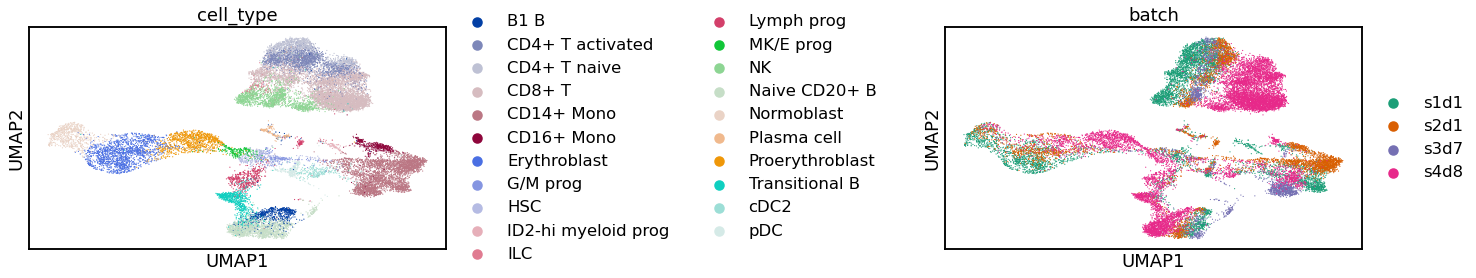

In [11]:
adata.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
]  # Set custom colours for batches
sc.pl.umap(adata, color=[label_key, batch_key], wspace=1)

Often when looking at these plots you will see clear separation between batches. In this case what we see is more subtle and while cells from the same label are generally near each other there is a shift between batchs. If we were to perform a clustering analysis using this raw data we would probably end up with some clusters containing a single batch which would be difficult to interpret at the annotation stage. We are also likely to overlook rare cell types which are not common enough in any single sample to produce their own cluster.

Now that we have confirmed there are batch effects to correct we can move on to the different integration methods. If the batched perfectly overlaid each other then there would be no need to perform integration.

## Batch-aware feature selection

As shown in previous chapters we often select a subset of genes to use for our analysis in order to reduce noise and processing time. We do the same thing when we have multiple batches however, it is important that gene selection is performed in a batch-aware way. This is because genes that are variable across the whole dataset could be capturing batch effects rather than the biological signals we are interested in.

We can perform batch-aware highly variable gene selection by setting the `batch_key` argument. **scanpy** will then calculate HVGs for each batch separately and combine the results by selecting those genes that are highly variable in the most batches.

***!!! TODO !!!*** - Check which HVG method to use here

In [12]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)
adata
adata.var

/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,feature_types,gene_id,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.5,GEX,ENSG00000241860,188,False,0.004929,0.673549,0.007133,1,False
LINC01409,GEX,ENSG00000237491,764,False,0.018855,0.646017,-0.733194,0,False
LINC01128,GEX,ENSG00000228794,881,False,0.022610,0.685406,0.199297,1,False
NOC2L,GEX,ENSG00000188976,977,False,0.024214,0.674026,-0.391298,0,False
KLHL17,GEX,ENSG00000187961,145,False,0.003606,0.653598,-0.247074,0,False
...,...,...,...,...,...,...,...,...,...
MT-ND5,GEX,ENSG00000198786,10920,False,0.369542,0.583063,-1.156446,0,False
MT-ND6,GEX,ENSG00000198695,3819,False,0.090493,0.640347,-0.343394,0,False
MT-CYB,GEX,ENSG00000198727,13859,False,0.549443,0.558554,-1.268154,0,False
AL592183.1,GEX,ENSG00000273748,1730,False,0.046654,0.691756,0.096679,0,False


We can see there are now some addtional columns in `var`:

* `highly_variable_nbatches` - The number of batches where each gene was found to be highly variable
* `highly_variable_intersection` - Whether each genes was highly variable in every batch
* `highly_variable` - Whether each genes was selected as highly variable after combining the results from each batch 

Let's check how many batches each gene was variable in:

0    9404
1    1967
2     832
4     685
3     543
Name: highly_variable_nbatches, dtype: int64

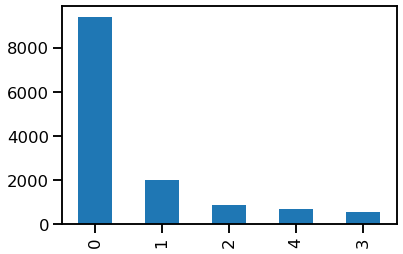

In [13]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

The first thing we notice is that most genes are not highly variable. This is typically the case but it can depend on how different the samples we are trying to integrate are. The overlap then decreases as we add more samples with relatively few genes being highly variable in all four batches. By selecting the top 2000 genes we have selected all HVGs that are present in three or four batches and most of those that are present in two batches.

> **How many genes to use?**
>
> This is a question which doesn't have a clear answer. The authors of the **scvi-tools** package which we use below recommend between 1000 and 10000 genes but how many depends on the context including the complexity of the dataset and the number of batches. 
> A survey from a previous best-practices paper {cite}`Lücken2019` indicated people typically use between 1000 and 6000 HVGs in a standard analysis.
> While selecting fewer genes can aid in the removal of batch effects {cite}`Lücken2022` (the most highly-variable genes often describe only dominant biological variation, we recommend selecting slightly too many genes than to select too few and risk removing genes which are important for a rare cell type or a pathway of interest.
> It should however be noted that more genes will also increase the time required to run the integration methods.

We will create an object with just the selected genes to use for integration.

In [14]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

## Removing batch effects via deep learning: conditional variational autoencoders

The first integration method we will use is **scVI**, a method based on a conditional variational autoencoder. A [variational autoencoder](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) is a type of artificial neural network which attempts to reduce the dimensionality of a dataset and reconstruct its distribution. The conditional part refers to explicitly considering differences between conditions (in this case batches) during this process in order to remove their effects. In benchmarking studies **scVI** has been shown to perform well across a range of datasets with a good balance of batch correction while conserving biological variability {cite}`Luecken2022`. **scVI** models raw counts directly, so it is important that we provide it with a count matrix rather than a normalized expression matrix.

First let's make a copy of our dataset to use for this integration. Normally it is not necessary to do this but as we will demonstrate multiple integration methods making a copy makes it easier to show what has been added by each method.

In [15]:
adata_scvi = adata_hvg.copy()

### Data preparation

The first step in using **scVI** is prepare our AnnData object. This step stores some information required by **scVI** such as which expression matrix to use and what the batch key is.

In [16]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

The fields created by **scVI** are prefixed with `_scvi`. These are designed for internal use and should not be manually modified. The general advice from **scVI** is that we should not to make any changes to our object until after the model is trained. On other datasets you may see a warning about `adata.layers["counts"]` containing unnormalised count data. This usually means you should check that the layer provided to the setup function does actually contain count values but it can also happen if you have values from performing gene length correction on data from a full-lenght protocol or from another quantification method that does not produce integer counts.

### Building the model

We can now construct an **scVI** model object. As well as the **scVI** model we use here the **scvi-tools** package contains various other models (we will use the **scANVI** model below).

In [17]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

The model object contains the provided AnnData object as well as the neural network for the model itself. You can see that currently the model is not trained. If we wanted to modify the structure of the network we could provide additional arguments to the model construction function but here we just use the defaults.

We can also print a more detailed description of the model that show us where things are stored in the associated AnnData object.

In [18]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 22091 │
│          n_vars          │ 2000  │
│         n_batch          │   4   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
│                    │    s4d8    │          3          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Here we can see exactly what information has been assigned by **scVI** and even details like how each different batch is encoded in the model.

### Training the model

The model will be trained for a given number of _epochs_ (a training iteration where every cell is passed through the network). The following code is a suggested heuristic for reducing the number of epochs for larger datasets. Since this dataset has slightly more than 20000 cells we get a value slightly below the default value of 400.

**!!! TODO !!!** - Check this is still the recommended thing to do with new scvi-tools versions

In [19]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

362

We now train the model for the selected number of epochs (this will take ~30-60 minutes depending on the computer you are using).

In [20]:
model_scvi.train(max_epochs=max_epochs_scvi)

/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Set SLUR

Epoch 362/362: 100%|██████████| 362/362 [44:26<00:00,  7.37s/it, loss=535, v_num=1]


> **Early stopping**
>
> An alternative to manually setting the number of epochs is to set `early_stopping=True` in the training function. This will let **scVI** decide to stop training early depending on the convergence of the model.
> The exact conditions for stopping can be controlled by other parameters.

### Extracting the embedding 

The main result we want to extract from the trained model is the latent representation for each cell. This is an embedding where the batch effects have been removed. We store this in `obsm` with the key `X_scvi`.

In [21]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

### Calculate corrected UMAP

We will now visualise the data as we did before integrated. We calculate a new UMAP embedding but instead of finding nearest neighbours in PCA space we start with the corrected representation from **scVI**.

In [22]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pc

Once we have the new UMAP representation we can plot it coloured by batch and identity labels as before.

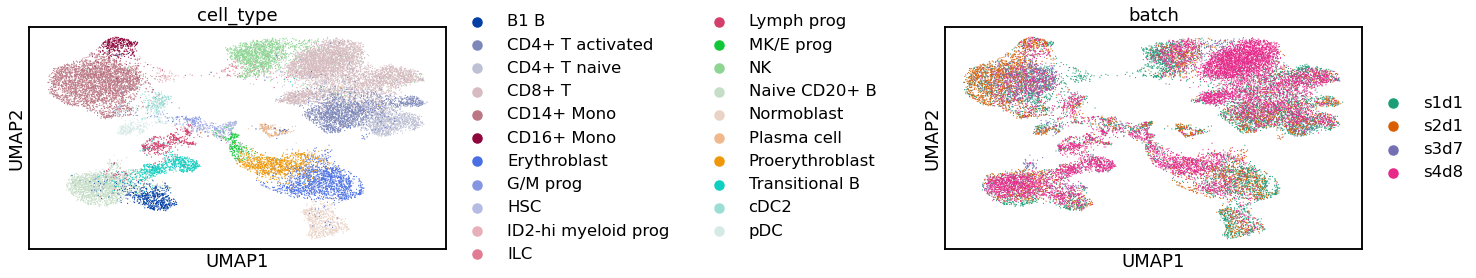

In [23]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

This looks better! Before, the various batches were shifted apart from each other. Now, the batches are more overlapping and we have a single blob for each cell identity label.

In many cases we would not already have identity labels so from this stage we would continue with clustering, annotation and further analysis as described in other sections.

## With cell labels

When performing integration with **scVI** we pretended that we didn't already have any cell labels (although we showed them in plots). While this scenario is common there are some cases where we do know something about cell identity in advance. Most often this is when we want to combine one or more publicly available datasets with data from a new study. When we have labels for at least some of the cells we can use **scANVI**. This is an extension of the **scVI** model that knows about cell labels as well as batches. Because it has this extra information it can try to keep the differences between cell labels while removing batch effects. Benchmarking suggests that **scANVI** tends to better preserve biological signals compared to **scVI** but sometimes it is not as effective at removing batch effects. While we have labels for all cells here it is also possible to use **scANVI** in a semi-supervised manner where labels are only provided for some cells.

> **Label harmonization**
>
> If you are using **scANVI** to integrate multiple datasets for which you already have labels it is important to first perform _label harmonization_.
> This refers to a process of checking that labels are consistent across the datasets that are being integrated.
> How best to do this is an open question but often requires input from subject-matter experts.

We start by creating a **scANVI** model object. Note that because **scANVI** refines an **scVI** model we provide that rather than an AnnData object. If we had not already trained an **scVI** model we would need to do that first. We also provide a key for the column of `adata.obs` which contains our cell labels as well as the label which corresponds to unlabelled cells. In this case all of our cells are labelled so we just provide a dummy value but in most cases it is important to check that this is set correctly so that **scANVI** knows which label to ignore. 

In [24]:
# Normally we would need to run scVI first but we have already done that here
# model_scvi = scvi.model.SCVI(adata_scvi) etc.
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key=label_key, unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, 
dispersion: gene, gene_likelihood: zinb
Training status: Not Trained

Anndata setup with scvi-tools version 0.16.4.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'cell_type',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'batch',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 22091 │
│          n_vars          │ 2000  │
│         n_batch          │   4   │
│         n_labels         │  22   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s2d1    │          1          │
│                    │    s3d7    │          2          │
│                    │    s4d8    │          3          │
└────────────────────┴────────────┴─────────────────────┘

                        labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │        B1 B         │          0          │
│                        │  CD4+ T activated   │          1          │
│                        │    CD4+ T naive     │          2          │
│                        │       CD8+ T        │          3          │
│                        │     CD14+ Mono      │          4          │
│                        │     CD16+ Mono      │          5          │
│                        │    Erythroblast     │          6          │
│                        │      G/M prog       │          7          │
│                        │         HSC         │          8          │
│                        │ ID2-hi myeloid prog │          9          │
│                        │         ILC         │         10          │
│                        │     Lymph prog      │         11          │
│                        │      MK/E prog      │         12          │
│                        │         NK          │         13          │
│                        │    Naive CD20+ B    │         14          │
│                        │     Normoblast      │         15          │
│                        │     Plasma cell     │         16          │
│                        │   Proerythroblast   │         17          │
│                        │   Transitional B    │         18          │
│                        │        cDC2         │         19          │
│                        │         pDC         │         20          │
│                        │     unlabelled      │         21          │
└────────────────────────┴─────────────────────┴─────────────────────┘

This model object is very similar to what we saw before for **scVI**. As mentioned previously we could modify the structure of the model network but here we just use the default.

Again we have a heuristic for selecting the number of training epochs. Note that this is much fewer than before as we are just refining the **scVI** model, rather than training a whole network from scratch.

In [25]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                             


/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Set SLUR

Epoch 10/10: 100%|██████████| 10/10 [01:50<00:00, 11.01s/it, loss=626, v_num=1]


We can extract the new latent representation from the model and create a new UMAP embedding as we did for **scVI**.

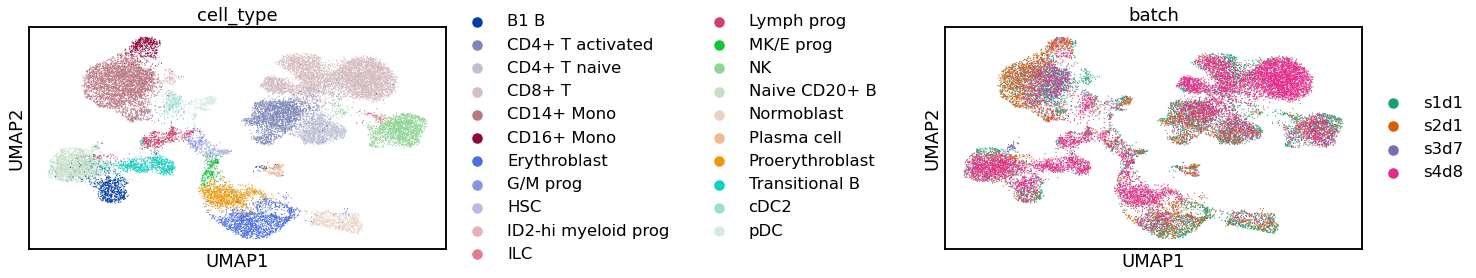

In [26]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=[label_key, batch_key], wspace=1)

By looking at the UMAP representation it is difficult to tell the difference between **scANVI** and **scVI** but when the effect of the refinement has been quantified it has been shown to often better preserve biological variation.

## Graph based

The next method we will look at is **BBKNN** or "Batch Balanced KNN". This is a very different approach to **scVI**, rather than using a neural network to embed cells in a batch-corrected space it instead modifies how the KNN graph used for clustering and embedding is constructed. As we have seen in previous chapters the normal KNN procedure connects cells to the most similar cells across the whole dataset. The change that **BBKNN** makes is to enforce that cells are connected to cells from other batches. While this is a simple modification it can be quite effective, particularly when there are very strong batch effects. However, as the result is an integrated graph it can have limited downstream uses as few packages will accept this as an input.

An important parameter for **BBKNN** is the number of neighbours per batch. A suggested heuristic for this is to use 25 if there are less than 10000 cells or the default of 3 if there are more than 10000.

In [27]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 10000 else 3

Before using **BBKNN** we first perform a PCA as we would before building a normal KNN graph. Unlike **scVI** which models raw counts here we start with the log-normalised expression matrix.

In [28]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

We can now run **BBKNN**, replacing the call to the **scanpy** `neighbors()` function in a standard workflow. An important difference is to make sure the `batch_key` argument is set which specifies a column in `adata_hvg.obs` which contains batch labels.

In [29]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'co

Unlike the default **scanpy** function **BBKNN** does not allow specifying a key for storing results so they are always stored under the default "neighbors" key.

We can use this new integrated graph just like we would a normal KNN graph to construct a UMAP embedding.

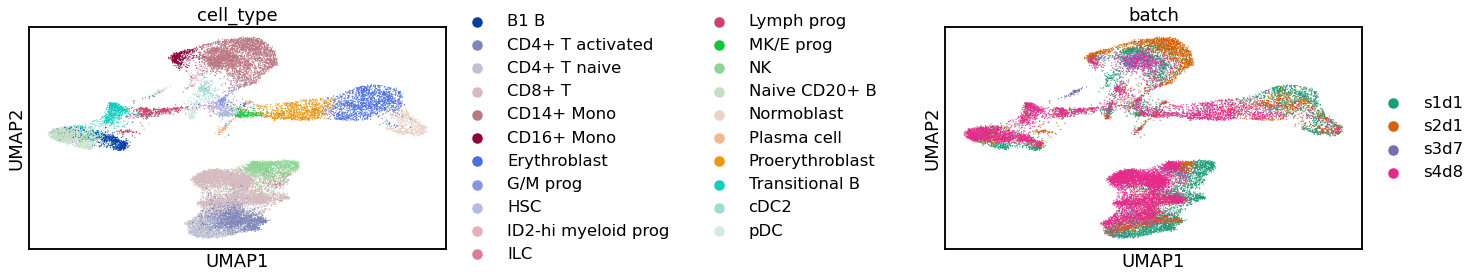

In [30]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=1)

This integration is also improved compared to the unintegrated data with cell identities grouped together but we sill see some shifts between batches.

## Linear embedding models

Some downstream applications cannot accept an integrated embedding or neighborhood graph and require a corrected expression matrix. One method that can produce this output is **Seurat**. The **Seurat** integration method is a method from the class of _linear embedding models_ that make use of the idea of _mutual nearest neighbors_ (which **Seurat** calls _anchors_) to correct the batch effect. _mutual nearest neighbors_ are pairs of cells from two different datasets which are in the neighborhood of each other when the datasets are placed in the same (latent) space. After finding these cells they can be used to align the two datasets and correct the differences between them. Seurat has also been found to one of the top mixing methods {cite}`Tran2020`.

As **Seurat** is an R package we must transfer our data from Python to R. Here we prepare the object to convert so that it can be handled by **rpy2** and **anndata2ri**.

**!!! TODO !!!** - See if can avoid densifying

In [31]:
adata_seurat = adata_hvg.copy()
# Convert categorical columns to strings
adata_seurat.obs[batch_key] = adata_seurat.obs[batch_key].astype(str)
adata_seurat.obs[label_key] = adata_seurat.obs[label_key].astype(str)
# Densify expression matrices
adata_seurat.X = adata_seurat.X.todense()
adata_seurat.layers["counts"] = adata_seurat.layers["counts"].todense()
adata_seurat.layers["logcounts"] = adata_seurat.layers["logcounts"].todense()
del adata_seurat.obsm  # Also contains sparse matrices we don't need
# Delete uns as this can contain arbitrary objects which are difficult to convert
del adata_seurat.uns
adata_seurat

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

The prepared object is now available in R as a SingleCellExperiment object thanks to **anndata2ri**. Note that this is transposed compared to an AnnData object so our observations (cells) are now the columns and our variables (genes) are now the rows).

In [32]:
%%R -i adata_seurat
adata_seurat

/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:261: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:195: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


class: SingleCellExperiment 
dim: 2000 22091 
metadata(0):
assays(3): X counts logcounts
rownames(2000): GPR153 ESPN ... DNASE1L1 CLIC2
rowData names(9): feature_types gene_id ... highly_variable_nbatches
  highly_variable_intersection
colnames(22091): TAGTTGTCACCCTCAC-1-s1d1 CTATGGCCATAACGGG-1-s1d1 ...
  AAGTCTATCTTAGTCT-14-s4d8 GAAGCCTGTTTGGGTA-14-s4d8
colData names(28): GEX_pct_counts_mt GEX_n_counts ... QCMeds
  DonorSmoker
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


**Seurat** uses it's own object to store data. Helpfully the authors provide a function to convert from SingleCellExperiment. We just provide the object and tell **Seurat** which assays (layers in our AnnData object) contain raw counts and normalised expression (which **Seurat** stores in a slot called "data").

In [33]:
%%R -i adata_seurat
seurat <- as.Seurat(adata_seurat, counts = "counts", data = "logcounts")
seurat

An object of class Seurat 
2000 features across 22091 samples within 1 assay 
Active assay: RNA (2000 features, 0 variable features)


Unlike some of the other methods we have seen which take a single object and a batch key, the **Seurat** integration functions require a list of objects. We create this using the `SplitObject()` function.

In [34]:
%%R -i batch_key
batch_list <- SplitObject(seurat, split.by = batch_key)
batch_list

$s1d1
An object of class Seurat 
2000 features across 6224 samples within 1 assay 
Active assay: RNA (2000 features, 0 variable features)

$s2d1
An object of class Seurat 
2000 features across 4220 samples within 1 assay 
Active assay: RNA (2000 features, 0 variable features)

$s3d7
An object of class Seurat 
2000 features across 1771 samples within 1 assay 
Active assay: RNA (2000 features, 0 variable features)

$s4d8
An object of class Seurat 
2000 features across 9876 samples within 1 assay 
Active assay: RNA (2000 features, 0 variable features)



We can now use this list to find anchors for each pairs of datasets. Usually you would identify batch-aware highly variable genes first (using the `FindVariableFeatures()` and `SelectIntegrationFeatures()` functions) but as we have done that already we tell **Seurat** to use all the features in the object.

In [35]:
%%R
anchors <- FindIntegrationAnchors(batch_list, anchor.features = rownames(seurat))
anchors

  |                                                  | 0 % ~calculating   |+++++++++++++                                     | 25% ~03s           |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++            | 75% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~02m 10s       |+++++++++++++++++                                 | 33% ~01m 22s       |+++++++++++++++++++++++++                         | 50% ~52s           |++++++++++++++++++++++++++++++++++                | 67% ~55s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~31s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03m 04s
An AnchorSet object containing 57268 anchors between 4 Seurat objects 
 This can be used as input to IntegrateData or TransferData

**Seurat** can then use the anchors to compute a transformation which maps one dataset onto another. This is done in a pairwise way until all the datasets are merged. By default **Seurat** will determine a merge order so that more similar datasets are merged together first but it is also possible to define this order. 

In [36]:
%%R
integrated <- IntegrateData(anchors)
integrated

An object of class Seurat 
4000 features across 22091 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA


The result is another Seurat object but notice now that the active assay is called "integrated". This contains the corrected expression matrix which is the final output of the integration.

Here we extract that matrix and prepare it for transfer back to Python.

In [37]:
%%R -o integrated_expr
# Extract the integrated expression matrix
integrated_expr <- as.matrix(GetAssayData(integrated))
# Make sure the rows and columns are in the same order as the original object
integrated_expr <- integrated_expr[rownames(seurat), colnames(seurat)]
# Transpose the matrix to AnnData format
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

                        GPR153 ESPN TNFRSF25 TNFRSF9 SPSB1 KAZN     PADI2 PADI4
TAGTTGTCACCCTCAC-1-s1d1      0    0        0       0     0    0 0.0000000     0
CTATGGCCATAACGGG-1-s1d1      0    0        0       0     0    0 0.0000000     0
CCGCACACAGGTTAAA-1-s1d1      0    0        0       0     0    0 0.1853299     0
TCATTTGGTAATGGAA-1-s1d1      0    0        0       0     0    0 0.0000000     0
ACCACATAGGTGTCCA-1-s1d1      0    0        0       0     0    0 0.0000000     0
TGGATTGGTTTGCGAA-1-s1d1      0    0        0       0     0    0 0.0000000     0
GTGAGCGAGTAAAGGT-1-s1d1      0    0        0       0     0    0 0.0000000     0
GACTTAGGTTGCGCGA-1-s1d1      0    0        0       0     0    0 0.0000000     0
GCCTTACTCGTTACAA-1-s1d1      0    0        0       0     0    0 0.0000000     0
GTAAGGTCAATAACCT-1-s1d1      0    0        0       0     0    0 0.0000000     0
                        CDA  ELOA-AS1
TAGTTGTCACCCTCAC-1-s1d1   0 0.0000000
CTATGGCCATAACGGG-1-s1d1   0 0.0000000
CCGCAC

We will now store the corrected expression matrix as a layer in our AnnData object. We also set `adata.X` to use this matrix.

In [38]:
adata_seurat.X = integrated_expr
adata_seurat.layers["seurat"] = integrated_expr
print(adata_seurat)
adata.X

AnnData object with n_obs × n_vars = 22091 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'seurat'
    obsp: 'distances', 'connectivities'


<22091x13431 sparse matrix of type '<class 'numpy.float32'>'
	with 23917995 stored elements in Compressed Sparse Row format>

Now that we have the results of our integration we can calculate a UMAP and plot it as we have for the other methods.

... storing 'cell_type' as categorical
... storing 'batch' as categorical


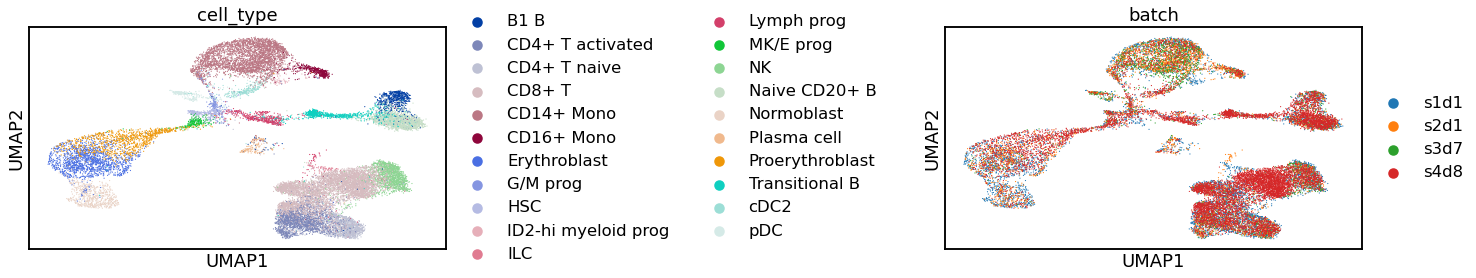

In [39]:
sc.tl.pca(adata_seurat)
sc.pp.neighbors(adata_seurat)
sc.tl.umap(adata_seurat)
sc.pl.umap(adata_seurat, color=[label_key, batch_key], wspace=1)

As we have previously seen, the batches are mixed while the labels are separated. It is tempting to select an integration based on the UMAPs but this does not fully represent the quality of an integration. In the next section we present some approaches to more rigorously evaluate integration methods.

## Benchmarking your own integration

The methods demonstrated here are selected based on results from benchmarking experiments including the [single-cell integration benchmarking project](https://theislab.github.io/scib-reproducibility/). This project also produced a software package called [**scib**](https://www.github.com/theislab/scib) that can be used to run a range of integration methods as well as the metrics that were used for evaluation. In this section we show how to use this package to evaluate the quality of an integration.

> **What is the ground truth?**
>
> Some of these metrics, particularly those that evaluate conservation of biological variation, require a known ground truth to compare to. Usually this is a cell identity label but can sometimes be other information such as known trajectories. Because of this requirement it is difficult to evaluate integration for a completely new dataset where it is unclear what biological signal should be preserved.

The **scib** metrics can be run individually but there are also wrappers for running multiple metrics at once. Here we run a subset of the metrics which are quick to compute using the `metrics_fast()` function. This function takes a few arguments: the original unintegrated dataset, the integrated dataset, a batch key and a label key. Depending on the output of the integration method we might also need to supply additional arguments, for example here we specify the embedding to use for **scVI** and **scANVI** with the `embed` argument. You can also control how some metrics are run with additional arguments.

Let's run the metrics for each of the integrations we have performed above, as well as the unintegrated data (after highly variable gene selection).

In [40]:
metrics_scvi = scib.metrics.metrics_fast(
    adata, adata_scvi, batch_key, label_key, embed="X_scVI"
)
metrics_scanvi = scib.metrics.metrics_fast(
    adata, adata_scanvi, batch_key, label_key, embed="X_scANVI"
)
metrics_bbknn = scib.metrics.metrics_fast(adata, adata_bbknn, batch_key, label_key)
metrics_seurat = scib.metrics.metrics_fast(adata, adata_seurat, batch_key, label_key)
metrics_hvg = scib.metrics.metrics_fast(adata, adata_hvg, batch_key, label_key)

Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...


Here is an example of what one of the metrics results looks like for a single integration:

In [41]:
metrics_hvg

,0
NMI_cluster/label,NaN
ARI_cluster/label,NaN
ASW_label,0.550467
ASW_label/batch,0.909000
PCR_batch,0.507870
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.475478
graph_conn,0.987786
kBET,NaN


Each row is a different metric and the values show the score for each metrics. Scores are between 0 and 1, where 1 is a good performance and 0 is a poor performance. Because we have only run the fast metrics here, some of the metrics have `NaN` scores. Also note that some metrics cannot be used with some output formats which can also be a reason for `NaN` values being returned.

To compare the methods it is useful to have all the metrics results in one table. This code combines them and tidies them into a more convenient format.

**!!! TODO !!!** - Check if HVG overlap should be excluded (maybe should only be calculated on expression output) -> yes, this should only be computed on expression output! Otherwise the output is just the unintegrated counts computed twice.

In [42]:
# Concatenate metrics results
metrics = pd.concat(
    [metrics_scvi, metrics_scanvi, metrics_bbknn, metrics_seurat, metrics_hvg],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["scVI", "scANVI", "BBKNN", "Seurat", "Unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
metrics

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.574195,0.899081,0.846422,0.513492,0.973778,1.0000
scANVI,0.594502,0.900252,0.813801,0.491256,0.976798,1.0000
BBKNN,0.555377,0.912848,0.507860,0.471376,0.994674,1.0000
Seurat,0.554370,0.922662,0.826818,0.456714,0.972622,0.5945
Unintegrated,0.550467,0.909000,0.507870,0.475478,0.987786,1.0000


We now have all the scores in one table with metrics as columns and methods as rows. Styling the table with a gradient can make it easier to see the differences between scores.

In [43]:
metrics.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.574195,0.899081,0.846422,0.513492,0.973778,1.000000
scANVI,0.594502,0.900252,0.813801,0.491256,0.976798,1.000000
BBKNN,0.555377,0.912848,0.507860,0.471376,0.994674,1.000000
Seurat,0.554370,0.922662,0.826818,0.456714,0.972622,0.594500
Unintegrated,0.550467,0.909000,0.507870,0.475478,0.987786,1.000000


For some metrics the scores tend to be in a relatively small range. To emphasise the differences between methods and place each metric on the same scale, we scale them so that the worst performer gets a score of 0, the best performer gets a score of 1 and the others are somewhere in between.

In [44]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap
scVI,0.538832,0.000000,1.000000,1.000000,0.052415,1.000000
scANVI,1.000000,0.049643,0.903648,0.608373,0.189377,1.000000
BBKNN,0.111505,0.583824,0.000000,0.258229,1.000000,1.000000
Seurat,0.088620,1.000000,0.942096,0.000000,0.000000,0.000000
Unintegrated,0.000000,0.420647,0.000030,0.330475,0.687636,1.000000


The values now better represent the differences between methods (and better match the colour scale). However, it is important to note that the scaled scores can only be used to compare the relative performance of this specific set of integrations. If we wanted to add another method we would need to perform the scaling again. We also can't say that an integration is definitively "good", only that it is better than the other methods we have tried. This scaling emphasises differences between methods. For example, if we had metric scores of 0.92, 0.94 and 0.96 these would be scaled to 0, 0.5 and 1.0. This makes the first method appear to score much worse, even though it is only slightly lower than the other two and still got a very high score. This effect is bigger when you are comparing few methods and when they get similar raw scores. Whether you look at raw or scaled scores depends on whether you want to focus on absolute performance or difference in performance between methods.

The evaluation metrics can be grouped into two categories, those that measure the removal of batch effects and those that measure the conservation of biological variation. We can calculate summary scores for each of these categories by taking the mean of the scaled values for each group. This kind of summary score wouldn't make sense with raw values as some metrics consistently produce higher scores than others.

In [45]:
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[
    ["ASW_label", "isolated_label_silhouette", "hvg_overlap"]
].mean(axis=1)
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap,Batch,Bio
scVI,0.538832,0.000000,1.000000,1.000000,0.052415,1.000000,0.350805,0.846277
scANVI,1.000000,0.049643,0.903648,0.608373,0.189377,1.000000,0.380890,0.869458
BBKNN,0.111505,0.583824,0.000000,0.258229,1.000000,1.000000,0.527941,0.456578
Seurat,0.088620,1.000000,0.942096,0.000000,0.000000,0.000000,0.647365,0.029540
Unintegrated,0.000000,0.420647,0.000030,0.330475,0.687636,1.000000,0.369438,0.443492


Plotting the two summary scores against each other gives an indication of the priorities of each method. Some will be biased towards batch correction while others will favour retaining biological variation.

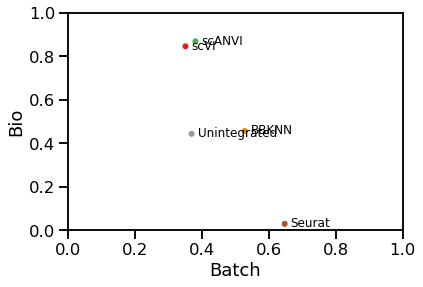

In [46]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
metrics_scaled.plot.scatter(
    x="Batch",
    y="Bio",
    c=range(len(metrics_scaled)),
    colormap=matplotlib.cm.get_cmap("Set1"),
    ax=ax,
)

for k, v in metrics_scaled[["Batch", "Bio"]].iterrows():
    ax.annotate(
        k,
        v,
        xytext=(6, -3),
        textcoords="offset points",
        family="sans-serif",
        fontsize=12,
    )

In our small example scenario it looks as though both **BBKNN** and **Seurat** have removed slightly more of the batch effects but also removed more more biological variation. Both **scVI** and **scANVI** score more highly on retaining biological variation, with **scANVI** being slightly better.

To get an overall score for each method we can combine the two summary scores. The **scIB** paper suggests a weighting of 40% batch correction and 60% biological conservation but you may prefer to weight things differently depending on the priorities for your dataset.

In [47]:
metrics_scaled["Overall"] = 0.4 * metrics_scaled["Batch"] + 0.6 * metrics_scaled["Bio"]
metrics_scaled.style.background_gradient(cmap="Blues")

,ASW_label,ASW_label/batch,PCR_batch,isolated_label_silhouette,graph_conn,hvg_overlap,Batch,Bio,Overall
scVI,0.538832,0.000000,1.000000,1.000000,0.052415,1.000000,0.350805,0.846277,0.648088
scANVI,1.000000,0.049643,0.903648,0.608373,0.189377,1.000000,0.380890,0.869458,0.674031
BBKNN,0.111505,0.583824,0.000000,0.258229,1.000000,1.000000,0.527941,0.456578,0.485123
Seurat,0.088620,1.000000,0.942096,0.000000,0.000000,0.000000,0.647365,0.029540,0.276670
Unintegrated,0.000000,0.420647,0.000030,0.330475,0.687636,1.000000,0.369438,0.443492,0.413870


Let's make a quick bar chart to visualise the overall performance.

<AxesSubplot:>

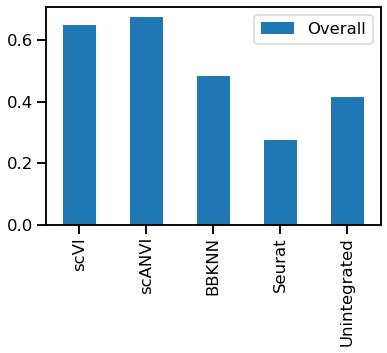

In [48]:
metrics_scaled.plot.bar(y="Overall")

As we have already seen **scVI** and **scANVI** are the best performers with **scANVI** scoring slightly higher. It is important to note that this is just an example of how to run these metrics for this specific dataset, not a proper evaluation of these methods. For that you should refer to existing benchmarking publications.

Existing benchmarks have suggested methods which generally perform well, but performance can also be quite variable across scenarios. For some analyses it may be worthwhile performing your own evaluation of integration. The **scib** package makes this process easier, but it can still be a significant undertaking, relying on a good knowledge of the ground truth and interpretation of the metrics.

## Key Takeaways

1. Visualize your data before attempting to correct for batch effects to assess the extent of the issue. Batch effect correction is not always required and it might mask the biological variation of interest.
2. If cell labels are available and biological variation is the most important, the usage of scANVI is advised.
3. Consider running several integration methods on your dataset and evaluate them with the scIB metrics to use the generated embedding that is most robust for your use-case.

## Quiz

1. Explain the difference between batch effects and data integration challenges.
2. What are sources of batch effects?
3. What is the difference between technical and biological variation?
4. How does one evaluate whether the integration worked well or not? What are useful metrics for this purpose?

## Session information

In [49]:
import session_info

session_info.show()

/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/jupyterlab_server/app.py:31: DeprecationWarning: metadata {'default': '2.8.2'} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  app_version = Unicode('', help='The version of the application.',
/home/icb/luke.zappia/miniconda3/envs/bp-integration/lib/python3.8/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


## References

```{bibliography}
:filter: docname in docnames
```